In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [2]:
filename = '../data/2019_oct_sort_1000.csv'

In [3]:
!pwd

/Users/helena/code/sailormoonvicky/eCommerce/notebooks


In [4]:
import random
p = 1  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df.shape

(1000, 9)

In [5]:
df.shape

(1000, 9)

In [6]:
df.category_code.nunique()

57

In [7]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [8]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-18 10:54:45 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
1,2019-10-18 10:55:20 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
2,2019-10-31 06:25:30 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.46,513782162,00000056-a206-40dd-b174-a072550fa38c
3,2019-10-31 06:25:52 UTC,view,5100816,2053013553375346967,NaN,xiaomi,29.60,513782162,00000056-a206-40dd-b174-a072550fa38c
4,2019-10-31 06:23:12 UTC,view,1005115,2053013555631882655,electronics.smartphone,apple,955.84,513782162,00000056-a206-40dd-b174-a072550fa38c


In [9]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [10]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/var/folders/6f/vn_j9pqn1qd8rp92y6x0h0hh0000gn/T/ipykernel_17849/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [11]:
X_preprocessed.shape

(445, 8)

## Pricing criterion

In [12]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [13]:
X_merged = pricing_criterion(X_preprocessed)

In [14]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [15]:
X_meta = metadata(X_merged)
X_meta.nunique()

event_type          3
product_id        310
category_id        61
category_code      50
brand              98
price             364
user_id           186
user_session      186
25%                50
75%                50
price_category      3
metadata          171
dtype: int64

In [16]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [17]:
print(X_meta.shape)
X_meta.head()

(445, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800017,view,49800017,2126679654801604876,accessories bag,ritmix,12.32,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,low,accessories bag ritmix low
49800020,view,49800020,2126679654801604876,accessories bag,ritmix,15.43,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,medium,accessories bag ritmix medium
28401080,view,28401080,2053013566209917945,accessories bag,respect,66.67,516007189,000037a4-c043-4113-9b53-7bbb5d7c2bfe,13.8750,41.0500,high,accessories bag respect high
28719157,view,28719157,2116907519078040377,apparel shoes,salamander,127.42,532234792,00006cdc-ee07-41db-958a-232b53a1f4fd,72.5875,88.4875,high,apparel shoes salamander high
28717170,view,28717170,2053013565639492569,apparel shoes,respect,84.43,557816044,000097b7-14fd-4336-a0e6-c82c981f8817,72.5875,88.4875,medium,apparel shoes respect medium


### Count Vectorizer

In [18]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(445, 170)


,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
49800017,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49800020,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28401080,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28719157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28717170,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
count_df_1 = count_df_1.reset_index()

In [20]:
len(list(set(count_df_1.index)))#.nunique()

445

In [21]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,product_id
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800017
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800020
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28401080
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28719157
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28717170


### Dimensionality reduction

In [22]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

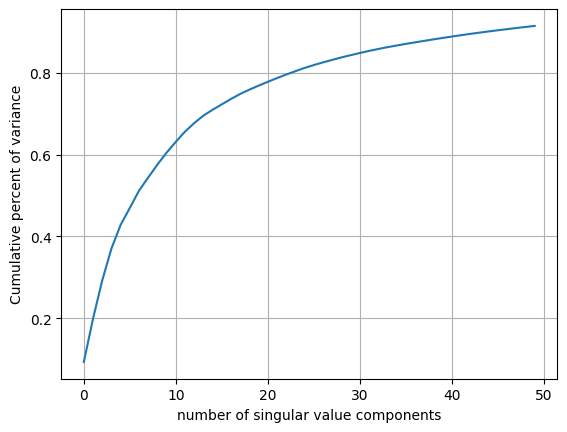

In [23]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [24]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [25]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(310, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
49800017,0.159126,0.094781,0.074467,0.867845,0.104342,0.451602,0.152625,-0.047068,0.053521,0.675642,...,-0.032940,-0.005631,-0.004889,-0.022120,-0.028062,-0.049581,0.006424,-0.005167,-0.010971,-0.001139
49800020,0.409155,-0.382170,0.576855,-0.308769,0.238508,0.484030,0.073801,0.038980,0.071821,0.701121,...,-0.041891,0.028501,-0.004594,-0.013861,-0.027703,-0.052800,0.005698,0.002181,-0.004237,0.004037
28401080,0.265688,0.819887,-0.069625,-0.261478,0.272532,0.385874,0.291194,0.005876,0.199421,0.596432,...,0.023481,-0.037745,-0.000663,-0.008421,-0.008242,-0.012315,-0.000664,-0.005111,-0.010196,-0.016081
28719157,0.274873,0.828929,-0.039082,-0.235706,0.326835,0.626002,0.366783,0.021173,0.926960,-0.465166,...,-0.034020,0.037193,0.003707,-0.022192,-0.033467,-0.014280,0.009623,-0.008531,-0.008986,0.009974
28717170,0.424708,-0.360599,0.624793,-0.291207,0.327407,0.838738,0.194364,0.061150,1.015400,-0.473332,...,0.057207,-0.037149,-0.000956,0.021163,0.027763,0.021792,-0.003528,0.010505,0.011601,0.005567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901444,0.405871,-0.403868,0.573468,-0.335038,0.207657,0.363650,0.009501,0.043420,0.016501,0.069495,...,0.012376,-0.004219,-0.002644,0.025231,0.012010,0.001766,-0.009974,0.050419,-0.089315,0.008549
10400294,0.156276,0.073684,0.071730,0.851527,0.074652,0.338353,0.090313,-0.043913,-0.001854,0.045490,...,0.033351,-0.057507,-0.008254,0.028258,0.016530,0.011026,-0.019119,0.097653,-0.201434,0.021974
10400334,0.406306,-0.403267,0.574117,-0.325087,0.208818,0.370782,0.011488,0.042135,0.016445,0.070969,...,0.024400,-0.023374,-0.007959,0.036516,0.016889,0.007808,-0.019844,0.105001,-0.194700,0.027150
10400398,0.259958,0.803929,-0.085135,-0.281876,0.228669,0.213571,0.211477,0.002942,0.025685,0.052357,...,-0.021407,0.016254,0.003826,-0.050152,-0.034534,-0.096337,0.029393,-0.176528,0.536571,0.049679


In [26]:
latent_df_1.reset_index().drop_duplicates().shape

(310, 51)

In [27]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [28]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [29]:
df_event = preprocessing_event(df)
df_event.user_id.nunique()

186

In [30]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [31]:
df_event['rating'] = df_event['event_type'].map(dct)

In [32]:
df_event["rating"].sum()

743

In [33]:
# df_rating.shape

In [34]:
# df_rating = df_event.pivot_table(values='rating',
#                                  index='product_id',
#                                  columns='user_id',
#                                  aggfunc="sum").fillna(0)
# df_rating

In [35]:
df_event.nunique()

event_time       609
event_type         3
product_id       310
category_id       61
category_code     50
brand             98
price            364
user_id          186
user_session     186
rating             3
dtype: int64

In [36]:
df_event.drop_duplicates(subset='product_id',inplace=True)
df_event.nunique()

event_time       310
event_type         3
product_id       310
category_id       61
category_code     50
brand             98
price            290
user_id          147
user_session     147
rating             3
dtype: int64

In [37]:
%%time

df_rating = df_event.pivot(values='rating',
               index='product_id',
               columns='user_id').fillna(0)

df_rating

CPU times: user 11.2 ms, sys: 2.32 ms, total: 13.6 ms
Wall time: 4.39 ms


user_id,512483064,512600925,512652590,512843699,512845701,512893095,513035269,513160929,513192914,513196971,...,562786298,562883054,563195675,563543861,563842008,564098956,564555327,564879838,565847508,566031240
product_id,,,,,,,,,,,,,,,,,,,,,
1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df_rating.sum().reset_index()[0].sum()

324.0

In [39]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    324
dtype: int64

In [40]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    324
dtype: int64

In [41]:
df_rating.reset_index()

user_id,product_id,512483064,512600925,512652590,512843699,512845701,512893095,513035269,513160929,513192914,...,562786298,562883054,563195675,563543861,563842008,564098956,564555327,564879838,565847508,566031240
0,1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,49800017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

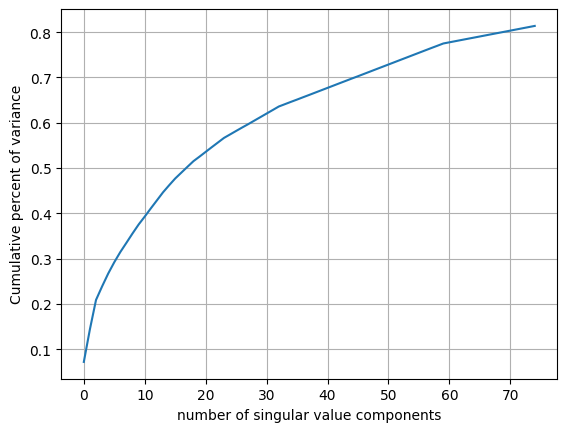

In [43]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [44]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
1002532,-2.855298e-12,-7.429852e-11,5.697370e-12,4.602040e-09,3.563042e-09,-8.150623e-09,1.715058e-08,-6.393423e-08,2.668072e-08,-6.468606e-10,...,-2.081668e-17,5.551115e-17,4.857226e-17,9.367507e-17,-1.318390e-16,1.838807e-16,7.285839e-17,1.144917e-16,2.428613e-16,1.873501e-16
1002540,-2.855298e-12,-7.429852e-11,5.697370e-12,4.602040e-09,3.563042e-09,-8.150623e-09,1.715058e-08,-6.393423e-08,2.668072e-08,-6.468606e-10,...,-2.081668e-17,5.551115e-17,4.857226e-17,9.367507e-17,-1.318390e-16,1.838807e-16,7.285839e-17,1.144917e-16,2.428613e-16,1.873501e-16
1002542,3.056532e-10,1.606329e-10,-9.042320e-10,-1.268031e-07,-2.796953e-08,-5.066317e-08,8.753602e-08,5.204530e-07,-9.629840e-07,-1.470380e-07,...,-1.709947e-02,-1.175685e-01,1.161301e-01,3.817682e-02,7.525532e-02,8.914541e-03,-5.516478e-02,-1.631163e-01,-1.809040e-01,-1.961448e-01
1002544,8.597428e-13,7.645513e-12,-1.471932e-10,-1.087698e-09,1.634793e-08,5.813455e-09,2.200704e-08,-2.635178e-09,-3.452279e-08,1.293207e-07,...,-2.463307e-16,0.000000e+00,-3.469447e-17,-4.683753e-17,-4.163336e-17,-2.081668e-17,3.642919e-16,3.469447e-17,-3.469447e-18,-2.914335e-16
1002633,8.597428e-13,7.645513e-12,-1.471932e-10,-1.087698e-09,1.634793e-08,5.813455e-09,2.200704e-08,-2.635178e-09,-3.452279e-08,1.293207e-07,...,-2.463307e-16,0.000000e+00,-3.469447e-17,-4.683753e-17,-4.163336e-17,-2.081668e-17,3.642919e-16,3.469447e-17,-3.469447e-18,-2.914335e-16


In [45]:
latent_df_2.shape

(310, 75)

In [2]:
filename_latent_df_1 = '../data/latent_df_1_with_0.75_data_50_svd_components.csv'

In [4]:
filename_latent_df_2 = '../data/latent_df_2_with_0.75_data_100_svd_components.csv'

In [5]:
filename_meta = '../data/X_meta_with_0.75_data.csv'

In [15]:
latent_df_1 = pd.read_csv(
         filename_latent_df_1
)
latent_df_1.shape

(97678, 51)

In [16]:
latent_df_2 = pd.read_csv(
         filename_latent_df_2
)
latent_df_1.shape

(97678, 51)

In [17]:
X_meta = pd.read_csv(
         filename_meta
)
X_meta.shape

(3857156, 13)

In [18]:
latent_df_1.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,1000894,0.479679,0.703705,-0.347103,-0.527718,0.653986,-0.486690,-0.036662,-0.083995,-0.047555,...,0.054260,0.190516,0.025682,-0.011648,-0.058354,0.053954,0.362089,-0.295604,-0.150441,0.200665
1,1000978,1.177724,-0.324887,0.813880,-0.550515,-0.759678,-0.284363,-0.160556,-0.054464,-0.050674,...,-0.002556,0.341302,0.000729,0.066601,-0.008678,0.103298,0.208929,-0.285964,-0.170319,0.338000
2,1001588,0.469582,0.767302,-0.390873,-0.540211,0.255217,0.894777,-0.774265,-0.731184,-0.122050,...,0.002785,-0.029138,0.009288,-0.003077,-0.001505,-0.019884,-0.050599,-0.020738,0.003819,0.016766
3,1001605,0.410104,0.302438,0.591097,0.386202,0.975642,-0.309749,-0.028792,-0.085603,-0.038355,...,0.045989,0.347607,0.073013,0.013252,-0.056804,0.067532,0.344986,-0.303446,-0.117945,0.161882
4,1001606,0.410104,0.302438,0.591097,0.386202,0.975642,-0.309749,-0.028792,-0.085603,-0.038355,...,0.045989,0.347607,0.073013,0.013252,-0.056804,0.067532,0.344986,-0.303446,-0.117945,0.161882


# Apply Cosine Similarity in Content and Collaborative Matrices


In [19]:
product_id=1001588

In [20]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

KeyError: 1001588

In [48]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [49]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [50]:
weight_features = 0.8

In [51]:
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)
recommendation_combined['hybrid'] = ((weight_features*recommendation_combined['features'] + (1-weight_features)*recommendation_combined['ratings']))

In [52]:
recommendation_combined.sort_values('ratings', ascending=False, inplace=True)
recommendation_combined

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
1004496,0.278535,0.643110,0.351450
5100343,1.000000,0.473845,0.894769
1801881,0.237376,0.433301,0.276561
1701553,0.232702,0.425851,0.271332
...,...,...,...
1801849,0.237376,-0.314840,0.126933
5100570,0.748006,-0.342422,0.529921
1003310,0.505746,-0.371649,0.330267
1701302,0.232528,-0.437624,0.098497


In [53]:
recommendation_combined.head()

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
1004496,0.278535,0.643110,0.351450
5100343,1.000000,0.473845,0.894769
1801881,0.237376,0.433301,0.276561
1701553,0.232702,0.425851,0.271332


In [54]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inouts for ranking: 'features', 'ratings', 'hybrid'"""
    
    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    
    return feat_idx
    
#     for i in feat_idx:
#         meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
#         lst = []
#         lst.append(meta_text)
#         return lst

In [55]:
indexes = top_n_products(recommendation_combined, X_meta, ranking='features')

In [65]:
indexes

Int64Index([ 5100337,  5100343,  5100566, 21400994,  1003306,  1002540,
             1002544,  1002633,  1003141,  1002532,
            ...
             2800501, 22900003, 22900007,  3700796,  3200573, 10201158,
             9100609, 45300048,  2900200,  3601244],
           dtype='int64', length=310)

In [56]:
len(indexes)

310

In [57]:
X_meta[X_meta.index.isin(indexes)]['metadata']

product_id
49800017       accessories bag ritmix low
49800020    accessories bag ritmix medium
28401080     accessories bag respect high
28719157    apparel shoes salamander high
28717170     apparel shoes respect medium
                        ...              
8901444           kids toys rubiks medium
10400294             kids toys rastar low
10400334          kids toys rastar medium
10400398            kids toys chicco high
27000002      sport trainer housefit high
Name: metadata, Length: 445, dtype: object

In [58]:
X_meta.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800017,view,49800017,2126679654801604876,accessories bag,ritmix,12.32,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,low,accessories bag ritmix low
49800020,view,49800020,2126679654801604876,accessories bag,ritmix,15.43,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,medium,accessories bag ritmix medium
28401080,view,28401080,2053013566209917945,accessories bag,respect,66.67,516007189,000037a4-c043-4113-9b53-7bbb5d7c2bfe,13.8750,41.0500,high,accessories bag respect high
28719157,view,28719157,2116907519078040377,apparel shoes,salamander,127.42,532234792,00006cdc-ee07-41db-958a-232b53a1f4fd,72.5875,88.4875,high,apparel shoes salamander high
28717170,view,28717170,2053013565639492569,apparel shoes,respect,84.43,557816044,000097b7-14fd-4336-a0e6-c82c981f8817,72.5875,88.4875,medium,apparel shoes respect medium


In [66]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inputs for ranking: 'features', 'ratings', 'hybrid'"""

    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    counter = 0
    
    product_ids=[]
    metas=[]
    prices=[]
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        price = meta_df[meta_df['product_id'] == i][['price']].iloc[0,:][0]
        
#         if counter == 0:
#             print(f"Top {n} recommendations for product_id {product_id}:")
#             print(f"{i} - {meta_text} {price} \n")
#             print("-----------------------")

#         else:
#             print(f"Rec {counter}) {i} - {meta_text} {price}")
        
        product_ids.append(i)
        metas.append(meta_text)
        prices.append(price)
        
        counter += 1
    
    new_df = pd.DataFrame({'product_id':product_ids, 'meta_text':metas, 'price':prices})
    
    return new_df.drop_duplicates('meta_text').iloc[:10,:]

In [67]:
top_n_products(recommendation_combined, X_meta, ranking='features')

,product_id,meta_text,price
0,5100337,electronics clocks apple medium,321.48
3,21400994,electronics clocks casio medium,325.10
4,1003306,electronics smartphone apple medium,581.12
11,5100573,electronics clocks apple high,455.61
14,5100861,electronics clocks samsung medium,390.68
17,8801018,electronics telephone nobby medium,24.26
18,5100765,electronics clocks garmin high,1671.74
19,1005069,electronics smartphone vivo medium,308.86
20,8800384,electronics telephone maxvi medium,33.21
21,21401225,electronics clocks casio low,48.13


In [61]:
new_df = top_n_products(recommendation_combined, X_meta, ranking='features')

In [62]:
new_df.drop_duplicates('meta_text').iloc[:10,:]

,product_id,meta_text,price
0,5100337,electronics clocks apple medium,321.48
3,21400994,electronics clocks casio medium,325.10
4,1003306,electronics smartphone apple medium,581.12
11,5100573,electronics clocks apple high,455.61
14,5100861,electronics clocks samsung medium,390.68
17,8801018,electronics telephone nobby medium,24.26
18,5100765,electronics clocks garmin high,1671.74
19,1005069,electronics smartphone vivo medium,308.86
20,8800384,electronics telephone maxvi medium,33.21
21,21401225,electronics clocks casio low,48.13


In [70]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inputs for ranking: 'features', 'ratings', 'hybrid'"""

    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    counter = 0
    
    product_ids=[]
    metas=[]
    prices=[]
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        price = meta_df[meta_df['product_id'] == i][['price']].iloc[0,:][0]
        
#         if counter == 0:
#             print(f"Top {n} recommendations for product_id {product_id}:")
#             print(f"{i} - {meta_text} {price} \n")
#             print("-----------------------")

#         else:
#             print(f"Rec {counter}) {i} - {meta_text} {price}")
        
        product_ids.append(i)
        metas.append(meta_text)
        prices.append(price)
        
        counter += 1
    
    new_df = pd.DataFrame({'product_id':product_ids, 'meta_text':metas, 'price':prices}).drop_duplicates('meta_text').iloc[:n,:]
    return new_df.reset_index().drop(columns='index')

In [71]:
top_n_products(recommendation_combined, X_meta, ranking='features', n=10)

,product_id,meta_text,price
0,5100337,electronics clocks apple medium,321.48
1,21400994,electronics clocks casio medium,325.10
2,1003306,electronics smartphone apple medium,581.12
3,5100573,electronics clocks apple high,455.61
4,5100861,electronics clocks samsung medium,390.68
5,8801018,electronics telephone nobby medium,24.26
6,5100765,electronics clocks garmin high,1671.74
7,1005069,electronics smartphone vivo medium,308.86
8,8800384,electronics telephone maxvi medium,33.21
9,21401225,electronics clocks casio low,48.13
